# Automatic Calibration Diagnosis: Interpreting Probability Integral Transform (PIT) Histograms

In [1]:
import functools
import math
import random

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib import gridspec
import pandas as pd
from scipy import stats
from sklearn.metrics.pairwise import euclidean_distances
import torch
import wandb

from calibration import data
from calibration import dist
from calibration import method
from calibration import pit
from calibration import plot

In [2]:
matplotlib.rcParams["font.size"] = 8
matplotlib.rcParams["axes.titlesize"] = 12
matplotlib.rcParams["figure.dpi"] = 600
matplotlib.rcParams["text.usetex"] = False
matplotlib.rcParams["font.family"] = "serif"

In [3]:
def param2pdf(weight, mean, variance):
    return lambda x: dist.pdf_gaussian_mixture(x, weight, mean, variance)

def y2pdf(w, s, v1, v2):
    weight = torch.tensor([w, 1 - w])
    mean = torch.tensor([-s / 2, s / 2])
    variance = torch.tensor([v1, v2])
    return param2pdf(weight, mean, variance)

## PIT histogram

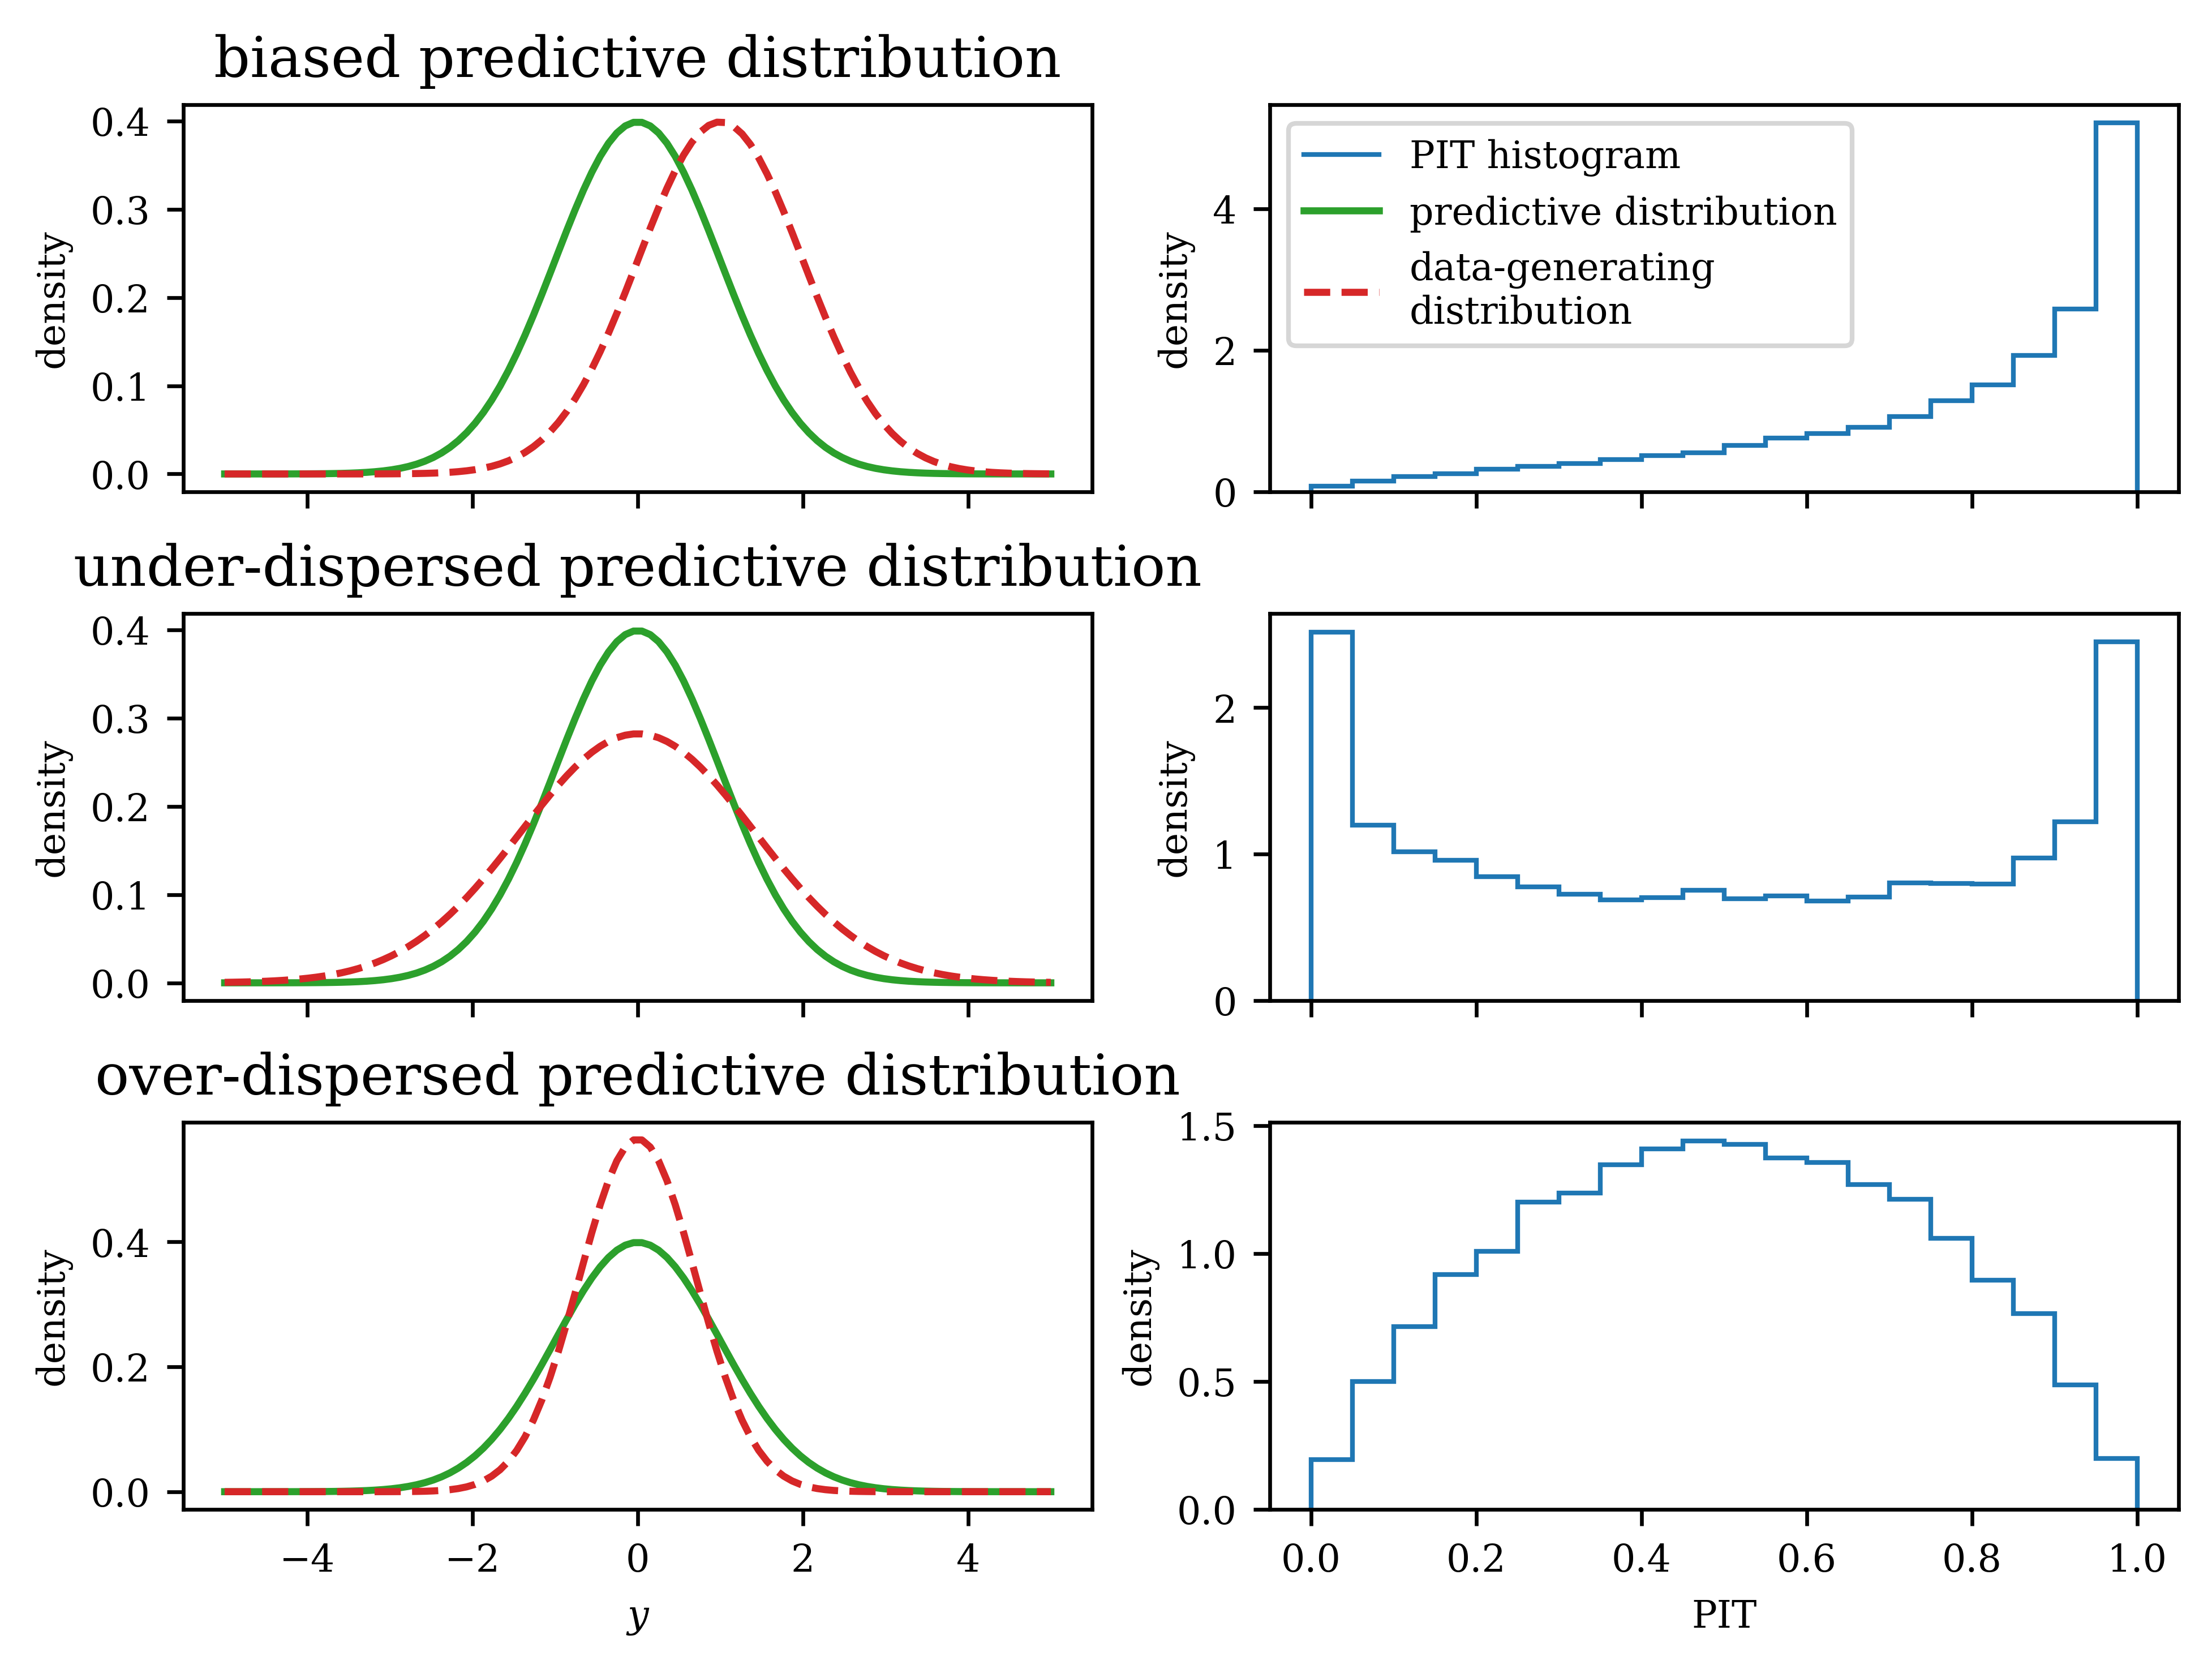

In [4]:
bias = (torch.tensor(1.0), torch.tensor(1.0), "biased")
under = (torch.tensor(0.0), torch.tensor(2.0), "under-dispersed")
over = (torch.tensor(0.0), torch.tensor(0.5), "over-dispersed")
_, axes = plt.subplots(nrows=3, ncols=2, sharex="col", constrained_layout=True)
for ax, (mean, variance, label) in zip(axes, [bias, under, over]):
    ax[0].set_title(f"{label} predictive distribution")
    y = mean + torch.sqrt(variance) * torch.randn(pit.SAMPLES)
    handle_pred = plot.density(ax[0], dist.pdf_gaussian, color="C2")
    dist_obs = functools.partial(dist.pdf_gaussian, mean=mean, variance=variance)
    handle_obs = plot.density(ax[0], dist_obs, color="C3", linestyle="--")
    handle_pit = plot.pit_hist(ax[1], pit.pit_hist(pit.pit_gaussian(y)))
    ax[0].set_ylabel("density")
    ax[1].set_ylabel("density")
axes[2, 0].set_xlabel("y", style="italic")
axes[2, 1].set_xlabel("PIT")
axes[0, 1].legend([handle_pit, handle_pred, handle_obs], ["PIT histogram", "predictive distribution", "data-generating\ndistribution"])

## Automatically interpreting PIT histograms

Text(0.5, 0.5, '1-Wasserstein distance')

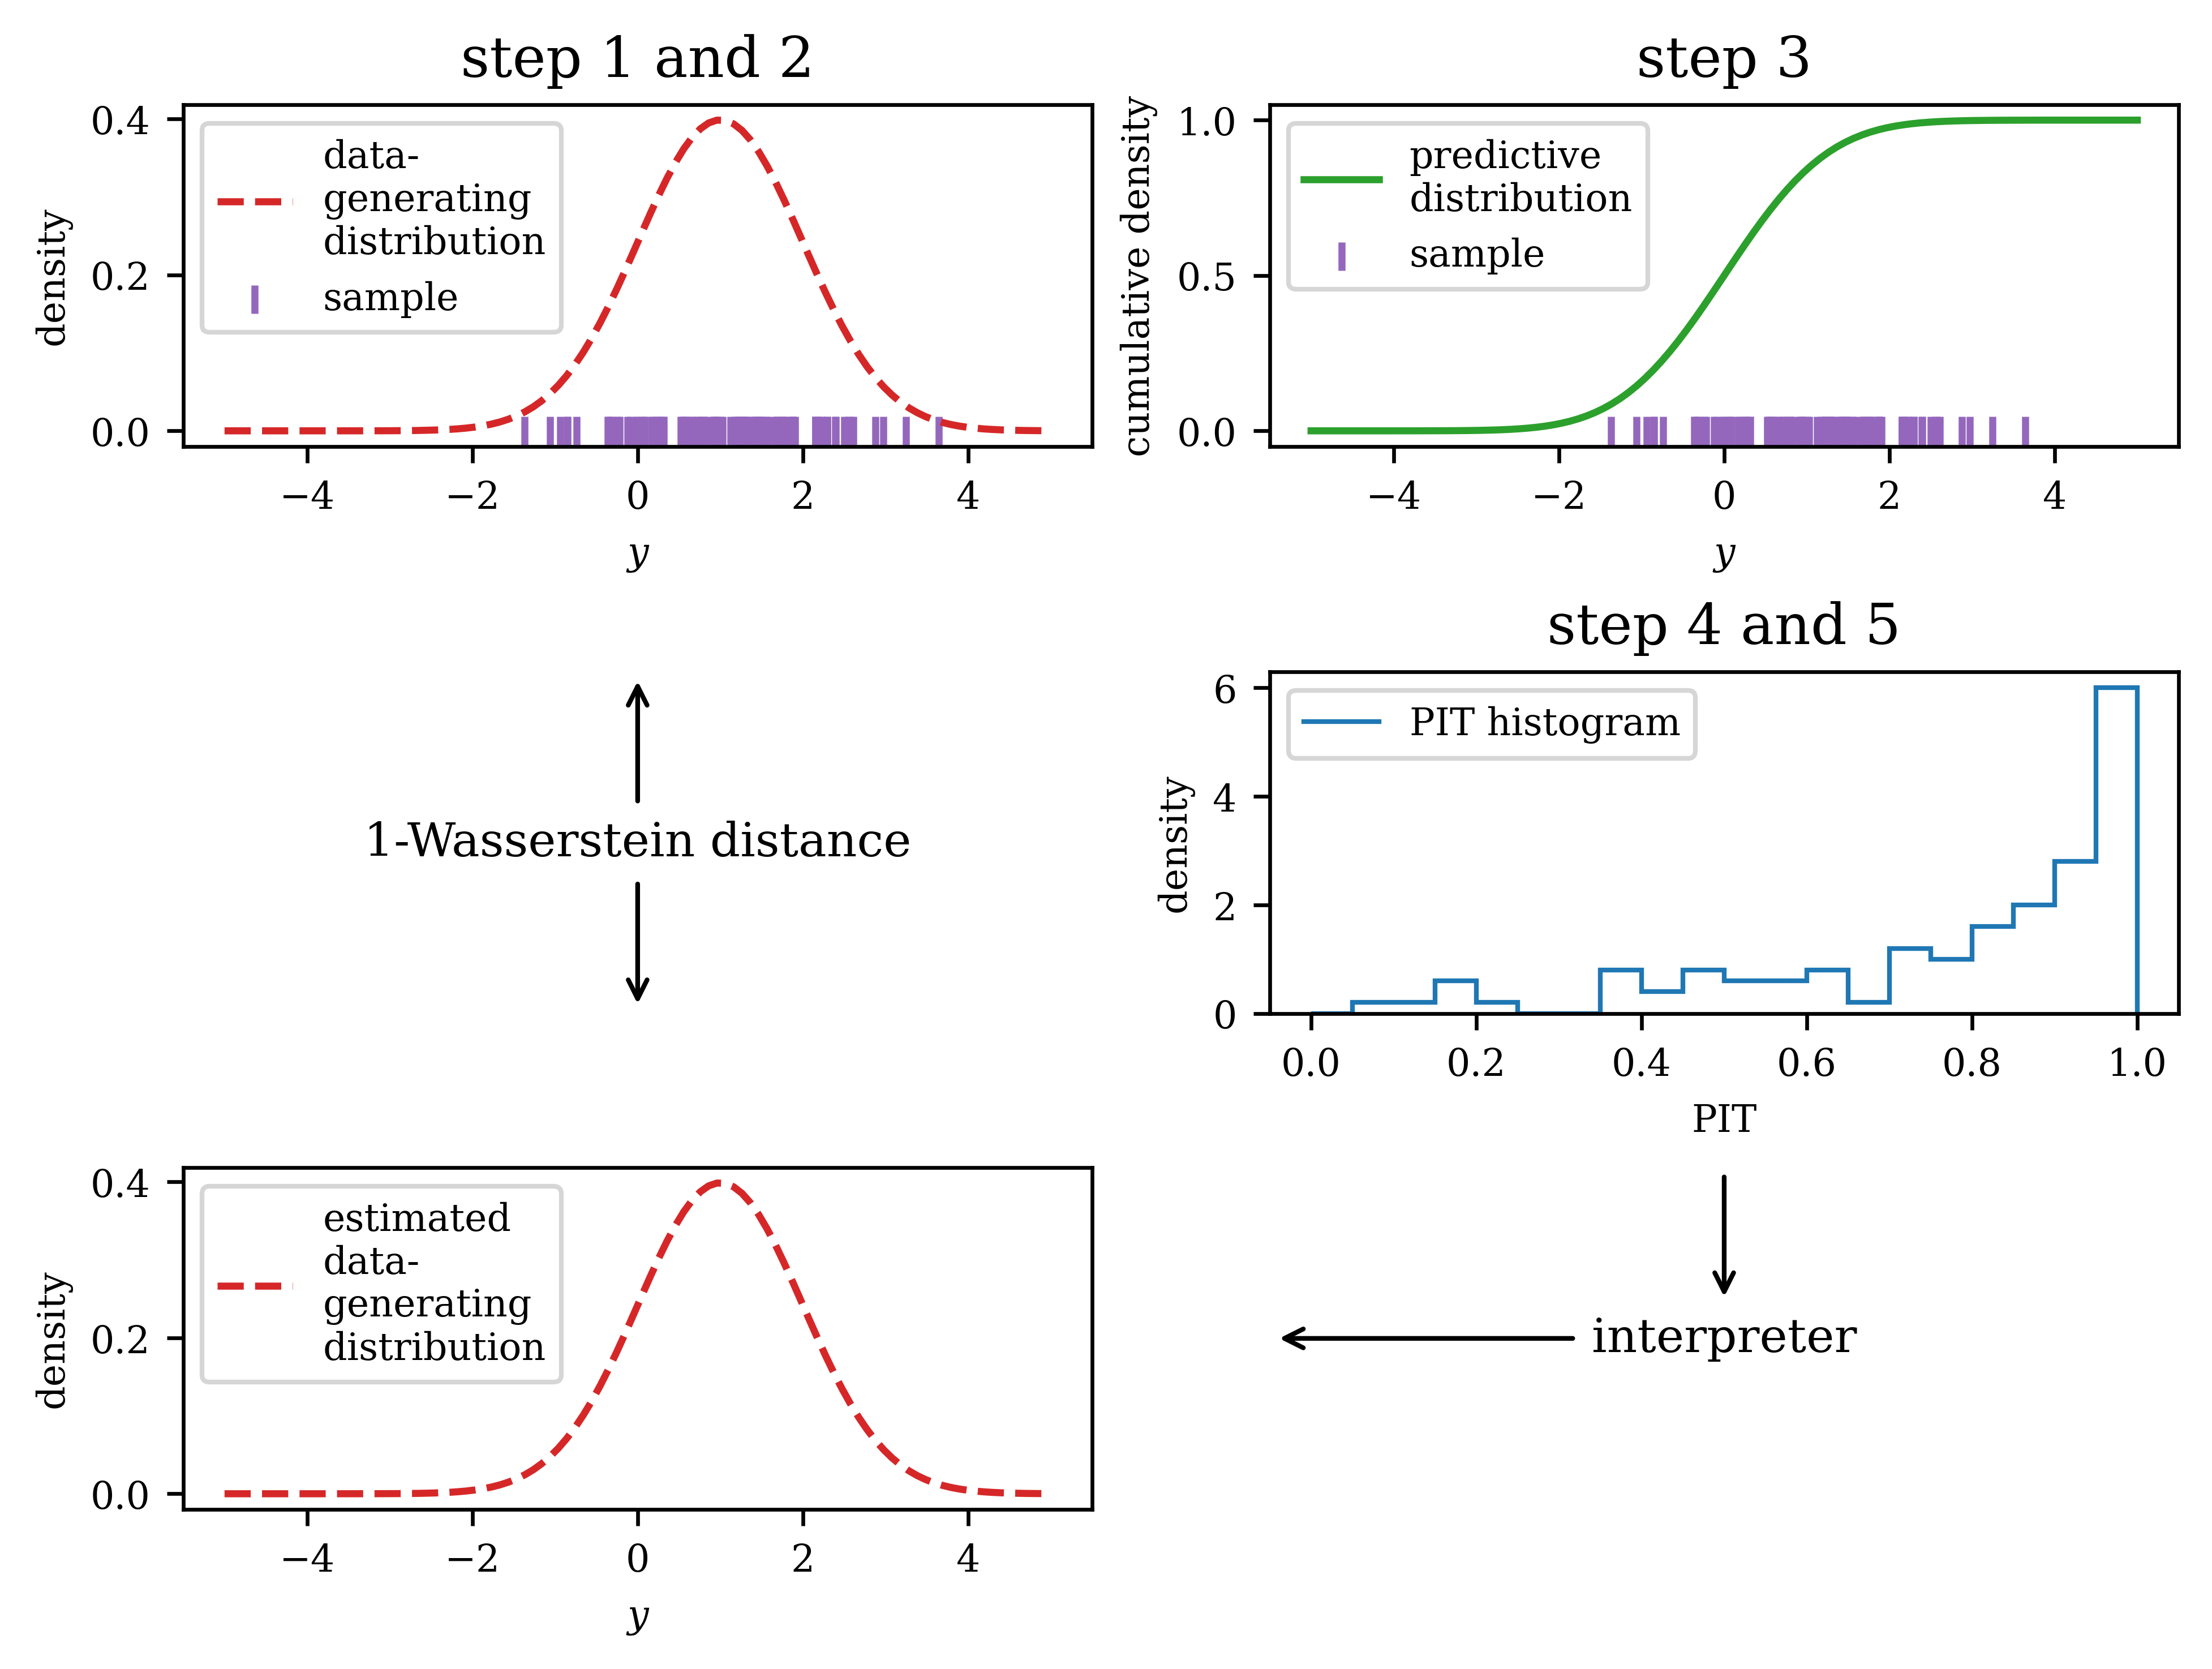

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=2, constrained_layout=True)
[[ax_obs, ax_pre], [ax_nll, ax_pit], [ax_pro, ax_int]] = axes
ax_obs.set_title("step 1 and 2")
mean = torch.tensor(1.0)
variance = torch.tensor(1.0)
pdf_obs = functools.partial(dist.pdf_gaussian, mean=mean, variance=variance)
plot.density(ax_obs, pdf_obs, color="C3", linestyle="--", label="data-\ngenerating\ndistribution")
y = mean + torch.sqrt(variance) * torch.randn(100)
ax_obs.scatter(y, torch.zeros_like(y), color="C4", marker="|", label="sample")
ax_obs.legend(loc="upper left")
ax_obs.set_xlabel("y", style="italic")
ax_obs.set_ylabel("density")
ax_pre.set_title("step 3")
cdf_pre = dist.cdf_gaussian
plot.cumulative_density(ax_pre, cdf_pre, color="C2", label="predictive\ndistribution")
ax_pre.scatter(y, torch.zeros_like(y), color="C4", marker="|", label="sample")
ax_pre.legend(loc="upper left")
ax_pre.set_xlabel("y", style="italic")
ax_pre.set_ylabel("cumulative density")
ax_pit.set_title("step 4 and 5")
plot.pit_hist(ax_pit, pit.pit_hist(pit.pit_gaussian(y)), label="PIT histogram")
ax_pit.legend(loc="upper left")
ax_pit.set_xlabel("PIT")
ax_pit.set_ylabel("density")
ax_int.set_axis_off()
textstyle = dict(va="center", ha="center", fontsize=10)
ax_int.annotate("interpreter", xy=(0.5, 1), xycoords="data", xytext=(0.5, 0.5), textcoords="data", arrowprops=dict(arrowstyle="<-"), **textstyle)
ax_int.annotate("interpreter", xy=(0, 0.5), xycoords="data", xytext=(0.5, 0.5), textcoords="data", arrowprops=dict(arrowstyle="->"), **textstyle, alpha=0.0)
plot.density(ax_pro, pdf_obs, color="C3", linestyle="--", label="estimated\ndata-\ngenerating\ndistribution")
ax_pro.legend(loc="upper left")
ax_pro.set_xlabel("y", style="italic")
ax_pro.set_ylabel("density")
ax_nll.set_axis_off()
ax_nll.annotate("1-Wasserstein distance", xy=(0.5, 1), xycoords="data", xytext=(0.5, 0.5), textcoords="data", arrowprops=dict(arrowstyle="->"), **textstyle)
ax_nll.annotate("1-Wasserstein distance", xy=(0.5, 0), xycoords="data", xytext=(0.5, 0.5), textcoords="data", arrowprops=dict(arrowstyle="->"), **textstyle, alpha=0.0)

## Interpreter

In [6]:
checkpoint = torch.load("models/legendary-pine-75.pt", map_location=torch.device('cpu') )
hyperparams = checkpoint["hyperparams"]
interpreter = method.MDN(inputs=hyperparams["bins"], neurons=hyperparams["neurons"], components=hyperparams["components"])
interpreter.load_state_dict(checkpoint["model_state_dict"])
interpreter

MDN(
  (linear1): Linear(in_features=20, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=15, bias=True)
)

## Uniform PIT histogram

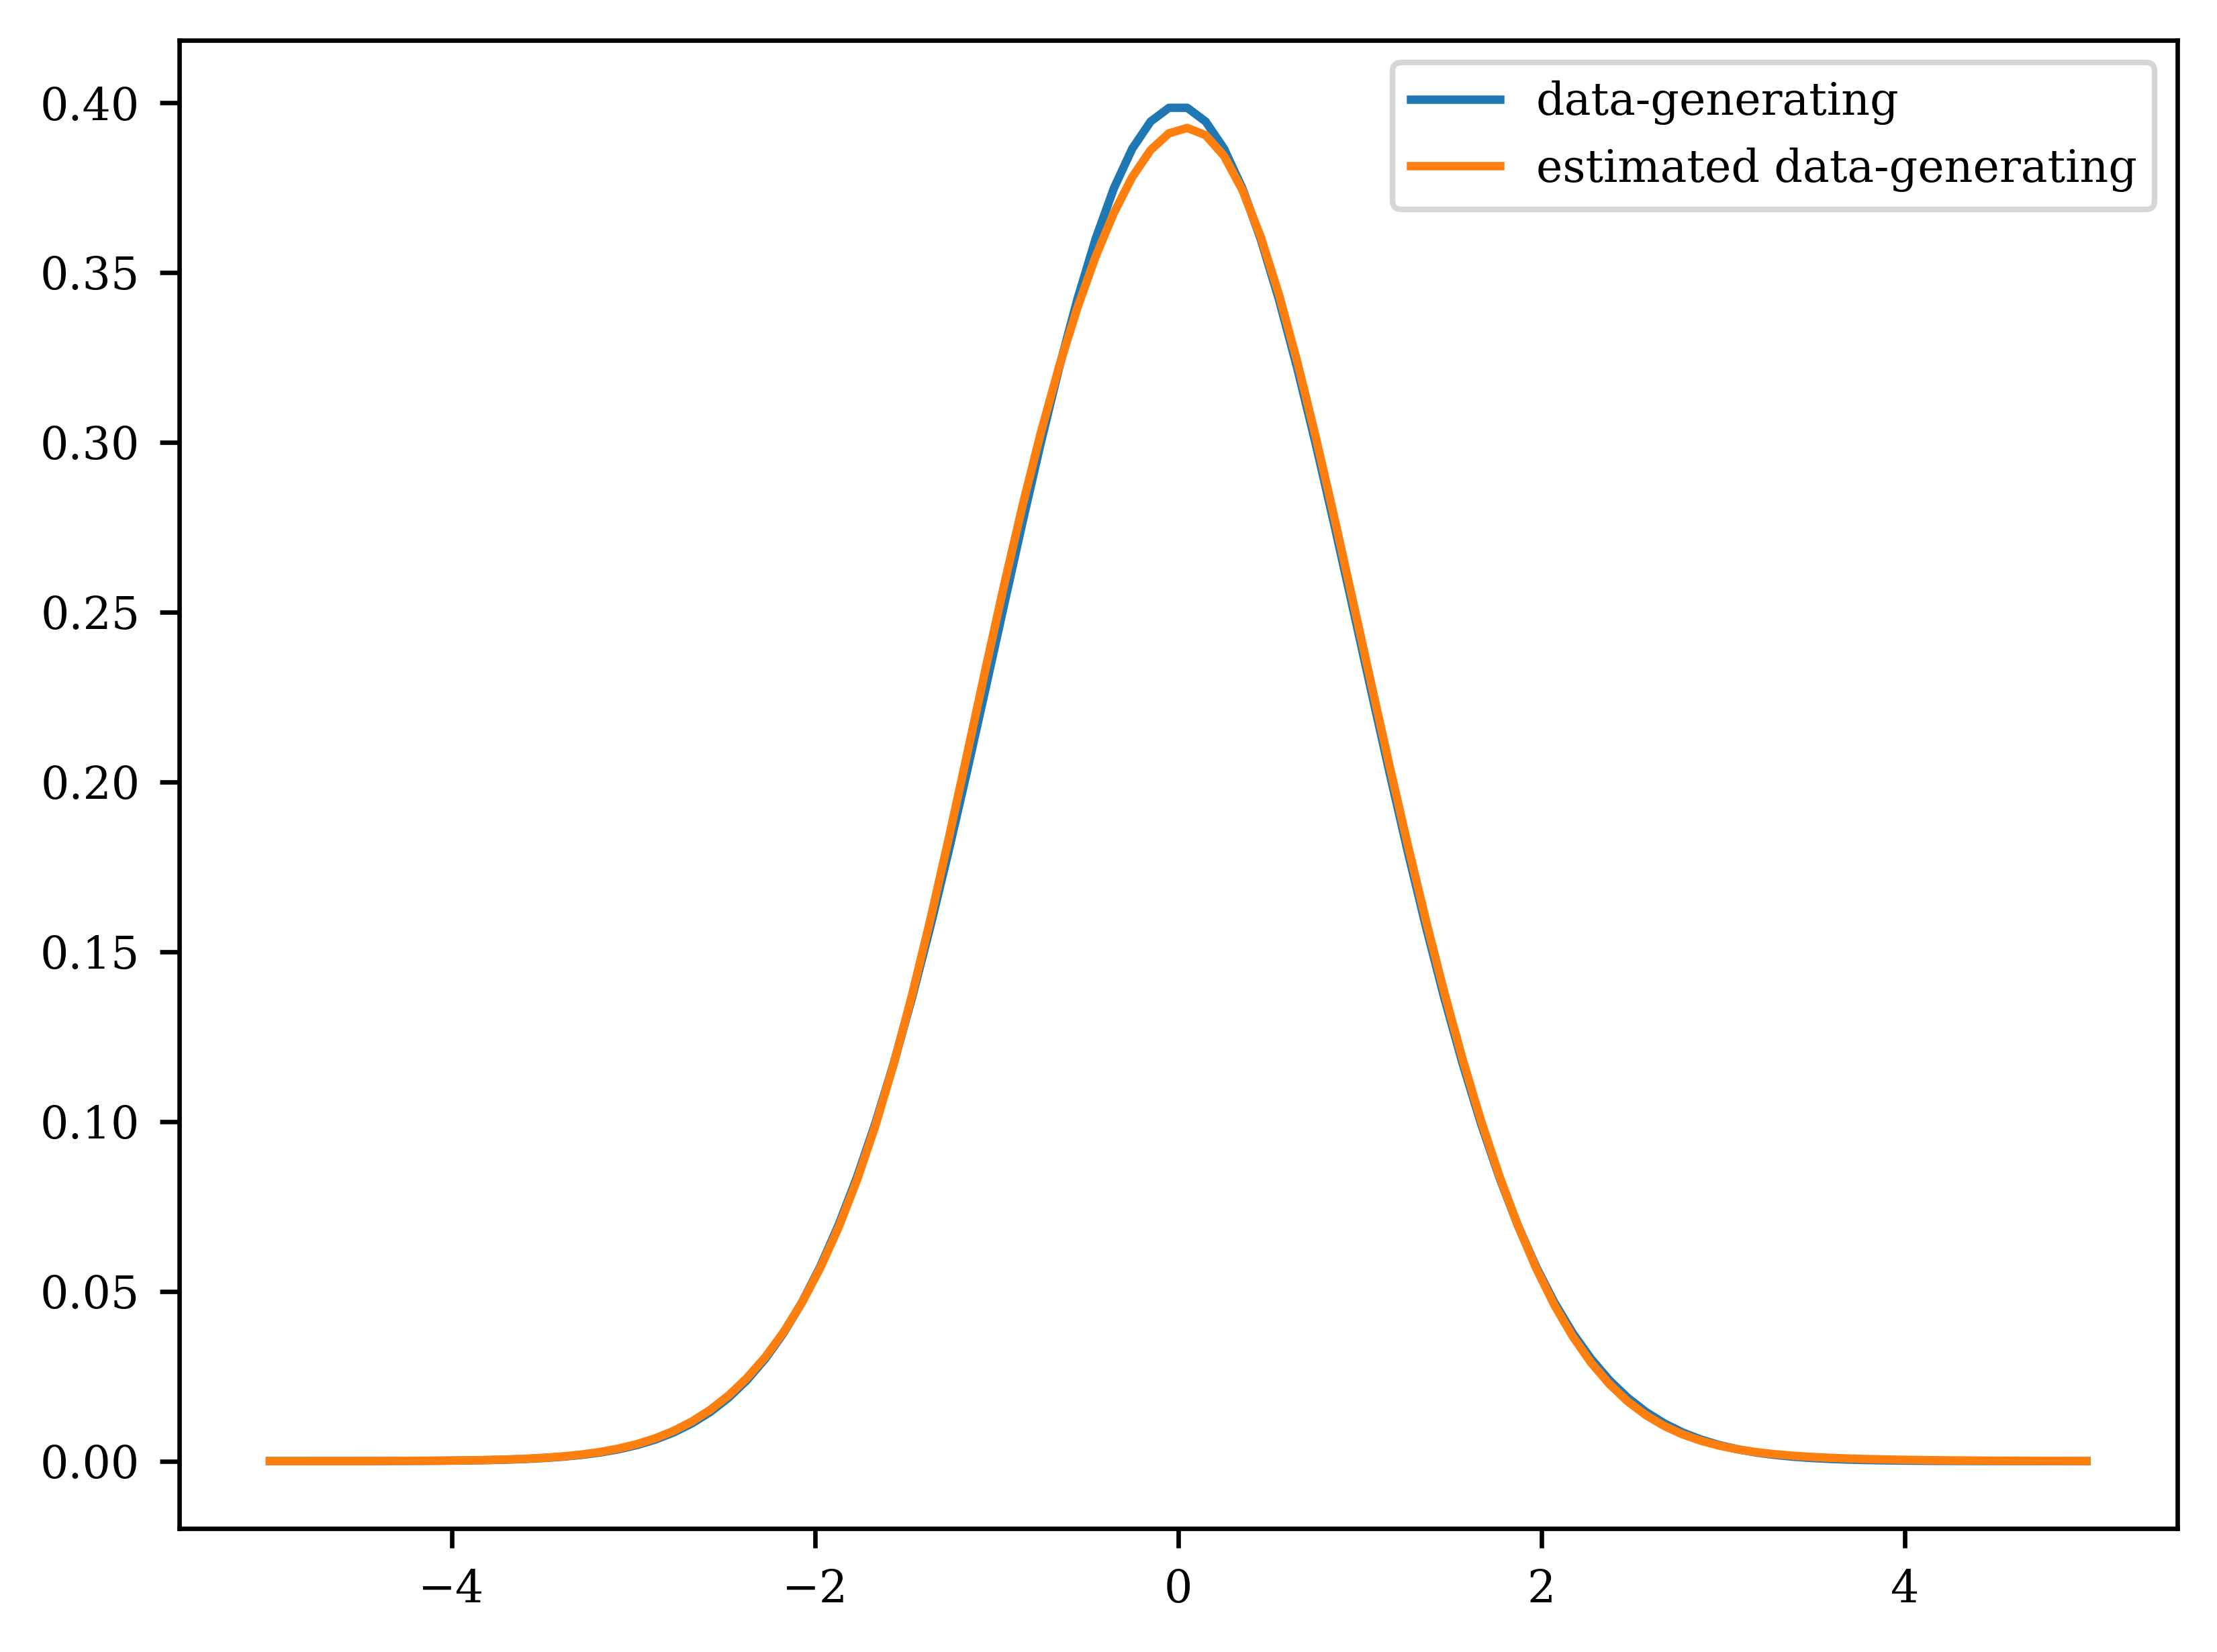

In [7]:
pit_hist_uniform = torch.full((pit.BINS, ), 1.0)
pred_uniform = method.predict(interpreter, pit_hist_uniform)
_, ax = plt.subplots()
plot.density(ax, dist.pdf_gaussian, label="data-generating")
plot.density(ax, param2pdf(*pred_uniform), label="estimated data-generating")
ax.legend()

## Evaluation

In [8]:
def load_model(modelfile, Model, keys):
    checkpoint = torch.load(modelfile, map_location=torch.device('cpu'))
    hyperparams = checkpoint["hyperparams"]
    model = Model(*[hyperparams[k] for k in ("inputs", "neurons") + keys])
    model.load_state_dict(checkpoint["model_state_dict"])
    return model

def load_mdn(modelfile):
    return load_model(modelfile, method.MDN, ("components", ))

def load_dn(modelfile):
    return load_mdn(modelfile)

def plot_interpretation(ax, interpretation):
    density_predictive = plot.density(ax, dist.pdf_gaussian, color="C2")
    density_interpret = plot.density(ax, param2pdf(*interpretation), color="C3", ls="--")
    return density_predictive, density_interpret

def pit_hist(model, dataset):
    alpha, mu, sigma = method.predict(model, dataset.X)
    pit_values = pit.pit_gaussian_mixture(dataset.y, alpha, mu, sigma)
    return pit.pit_hist(pit_values)

def diagnose(pit_hist, ax_pit, ax_dist, interpreter=interpreter):
    interpretation = method.predict(interpreter, pit_hist)
    pit_hist_interpreter = pit.pit_hist(pit.pit_gaussian(dist.sample_gaussian_mixture(*interpretation)))
    hist_pred = plot.pit_hist(ax_pit, pit_hist_interpreter)
    density_predictive, density_interpret = plot_interpretation(ax_dist, interpretation)
    return hist_pred, density_predictive, density_interpret

### Metrics

In [9]:
api = wandb.Api()
runs = api.runs("calibration")

keys = ["dataname", "method", "seed", "neurons"]
methods = ["mdn", "dn"]
datanames = ["year", "protein", "power"]
dicts, names = [], []
for run in runs:
    try:
        if run.config["method"] not in methods or run.config["dataname"] not in datanames:
            continue
        dictionary = {k: run.config[k] for k in keys}
        dictionary["nll"] = run.summary["test.nll"]
        dictionary["crps"] = run.summary["test.crps"]
    except KeyError:
        continue
    dicts.append(dictionary)
    names.append(run.name)

df = pd.DataFrame(data=dicts, index=names)
df = df.sort_values(["dataname", "method", "seed"])
df = df.drop_duplicates()
gdf = df.groupby(["dataname", "method"])
df

,dataname,method,seed,neurons,nll,crps
polished-star-1,power,dn,4,50,2.824620,2.261268
clear-elevator-10,power,dn,7,50,2.808561,2.151029
fiery-feather-11,power,dn,8,50,2.829679,2.231070
eager-wood-12,power,dn,9,50,2.732653,2.108211
morning-flower-13,power,dn,15,50,2.777246,2.123941
civilized-carrier-209,power,mdn,4,50,2.824620,2.261267
effortless-firefly-2,power,mdn,4,50,2.710357,2.165893
young-energy-14,power,mdn,7,50,2.670707,2.124304
rose-morning-14,power,mdn,8,50,2.736374,2.186282
firm-pond-17,power,mdn,9,50,2.626472,2.015196


In [10]:
gdf["nll"].agg(["mean", "sem"])

mean       sem
dataname method                    
power    dn      2.794552  0.017980
         mdn     2.698262  0.031327
protein  dn      2.804612  0.039376
         mdn     2.085908  0.016889
year     dn      3.372904  0.003265
         mdn     3.093512  0.001768

In [11]:
gdf["crps"].agg(["mean", "sem"])

mean       sem
dataname method                    
power    dn      2.175104  0.030190
         mdn     2.120865  0.044454
protein  dn      2.341886  0.024816
         mdn     1.939665  0.019076
year     dn      4.322462  0.013480
         mdn     4.039576  0.007017

### Synthetic

In [12]:
_, _, syntheticset = data.split(*data.synthetic(), scale=False, seed=4)

In [13]:
pit_hist_dn_synthetic = pit_hist(load_dn("models/true-durian-193.pt"), syntheticset)
pit_hist_mdn_synthetic = pit_hist(load_mdn("models/swift-snow-203.pt"), syntheticset)

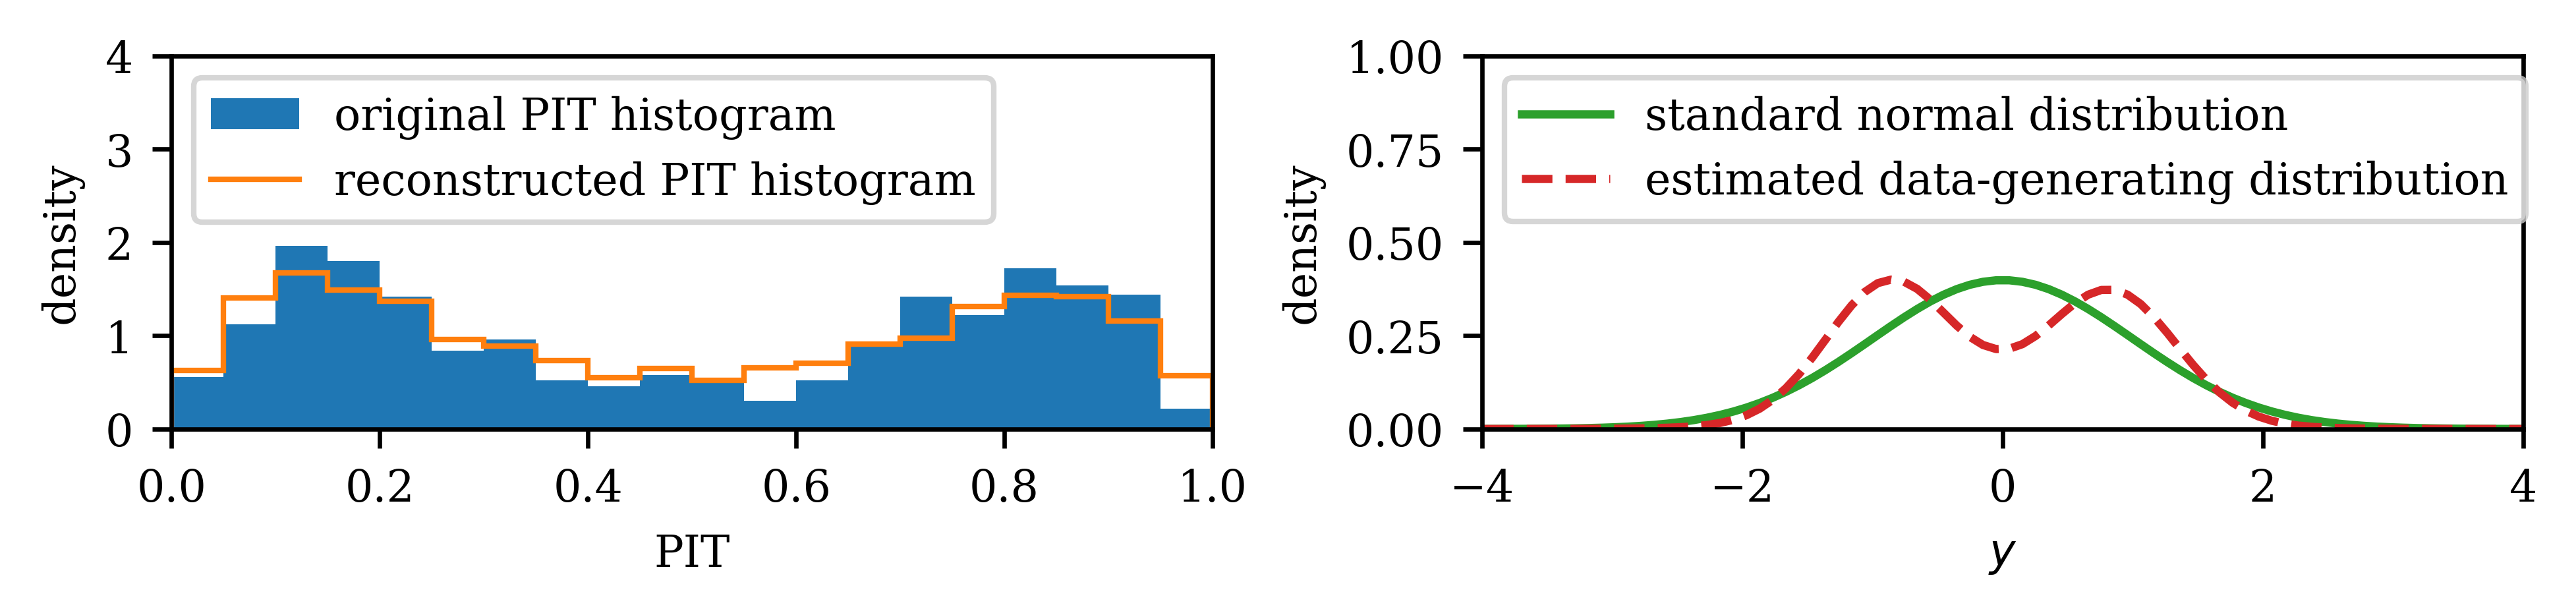

In [14]:
fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(6.4, 4.8 * 0.3))
hist_true = plot.pit_hist(axes[0], pit_hist_dn_synthetic, fill=True)
hist_pred, density_predictive, density_interpret = diagnose(pit_hist_dn_synthetic, axes[0], axes[1])
axes[1].set_xlabel("$y$")
axes[0].set_ylabel("density")
axes[1].set_ylabel("density")
axes[0].set_xlabel("PIT")
axes[0].legend([hist_true, hist_pred], ["original PIT histogram", "reconstructed PIT histogram"], loc="upper left")
axes[1].legend([density_predictive, density_interpret], ["standard normal distribution", "estimated data-generating distribution"], loc="upper left")
axes[0].set_ylim(0, 4)
axes[0].set_xlim(0, 1)
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(0, 1)
plt.savefig("figures/synthetic.pdf")

### UCI Machine Learning Repository

In [15]:
_, _, yearset = data.split(*data.year(), scale=True, seed=4)

In [16]:
pit_hist_dn_year = pit_hist(load_dn("models/rich-dragon-8.pt"), yearset)
pit_hist_mdn_year = pit_hist(load_mdn("models/chocolate-sound-9.pt"), yearset)

In [17]:
_, _, proteinset = data.split(*data.protein(), scale=True, seed=4)

In [18]:
pit_hist_dn_protein = pit_hist(load_dn("models/super-durian-4.pt"), proteinset)
pit_hist_mdn_protein = pit_hist(load_mdn("models/lucky-moon-5.pt"), proteinset)

In [19]:
_, _, powerset = data.split(*data.power(), scale=True, seed=4)

In [20]:
pit_hist_dn_power = pit_hist(load_dn("models/polished-star-1.pt"), powerset)
pit_hist_mdn_power = pit_hist(load_mdn("models/effortless-firefly-2.pt"), powerset)

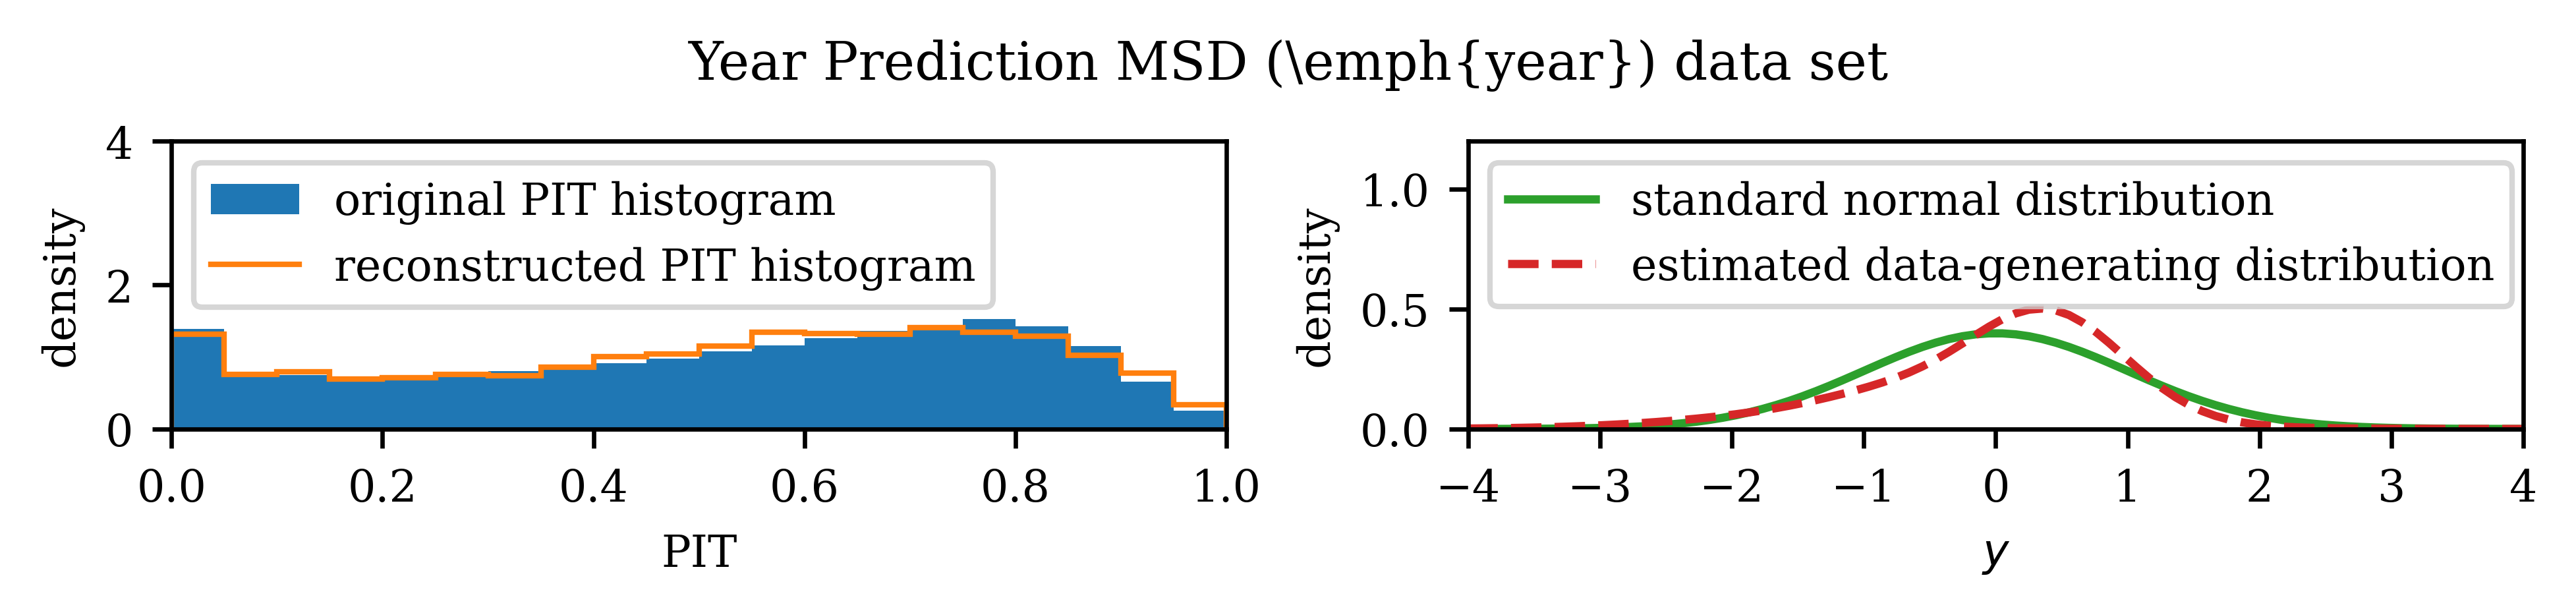

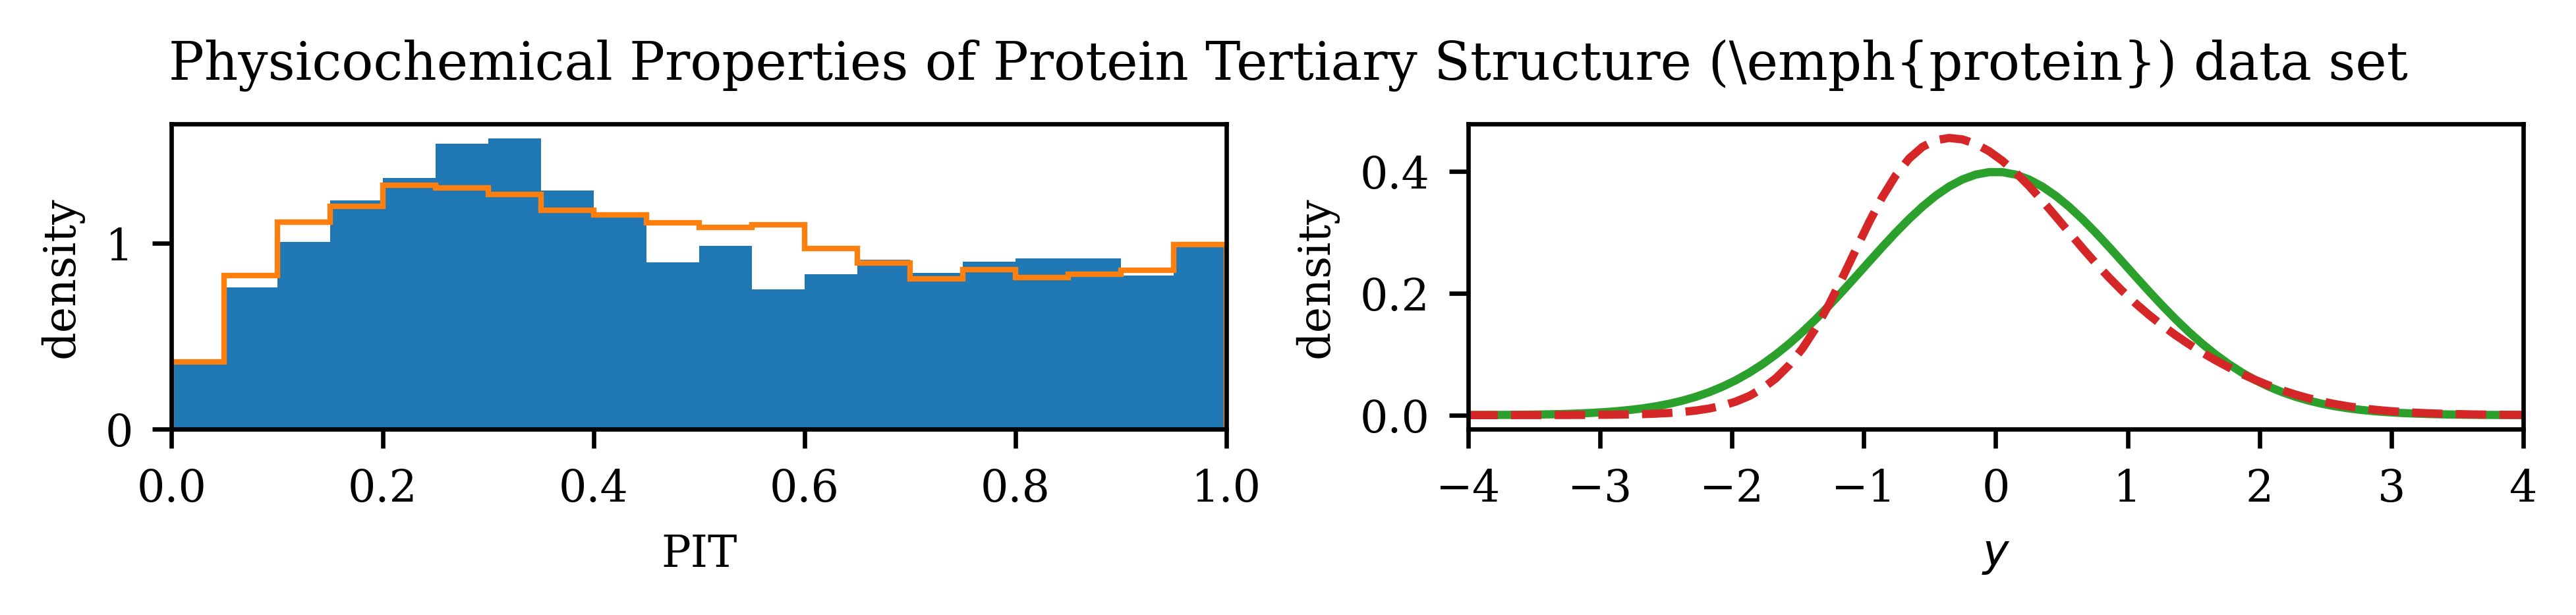

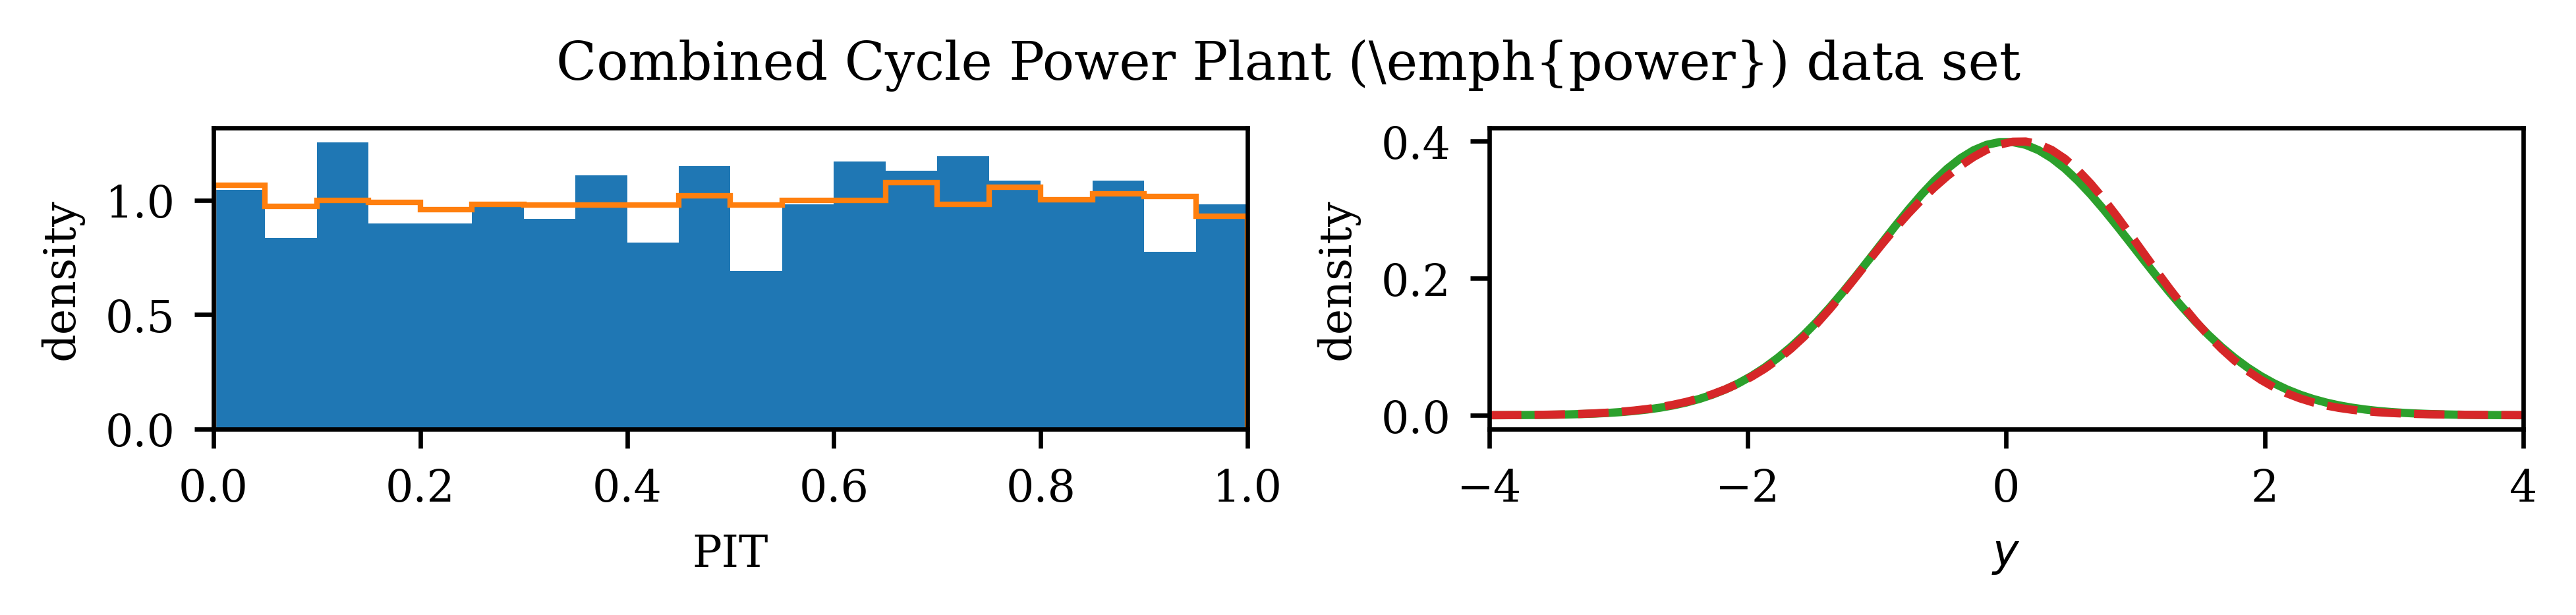

In [21]:
pit_hists_dn = [pit_hist_dn_year, pit_hist_dn_protein, pit_hist_dn_power]
names = ["year", "protein", "power"]
titles = [
    "Year Prediction MSD (\emph{year}) data set",
    "Physicochemical Properties of Protein Tertiary Structure (\emph{protein}) data set",
    "Combined Cycle Power Plant (\emph{power}) data set"
]
for name, title, pit_hist_dn in zip(names, titles, pit_hists_dn):
    fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(6.4, 4.8 * 0.3))
    fig.suptitle(title)
    hist_true = plot.pit_hist(axes[0], pit_hist_dn, fill=True)
    hist_pred, density_predictive, density_interpret = diagnose(pit_hist_dn, axes[0], axes[1])
    axes[1].set_xlabel("$y$")
    axes[0].set_ylabel("density")
    axes[1].set_ylabel("density")
    axes[0].set_xlabel("PIT")
    axes[0].set_xlim(0, 1)
    axes[1].set_xlim(-4, 4)
    if name == "year":
        axes[0].legend([hist_true, hist_pred], ["original PIT histogram", "reconstructed PIT histogram"], loc="upper left")
        axes[1].legend([density_predictive, density_interpret], ["standard normal distribution", "estimated data-generating distribution"], loc="upper left")
        axes[0].set_ylim(0, 4)
        axes[1].set_ylim(0, 1.2)
    plt.savefig(f"figures/{name}.pdf")